## Day 3 - Constructing the sitcom network

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
co_df = pd.read_csv("data/the_office_speaker_combinations.csv")
co_df.head(10)

,season,episode,scene,speaker1,speaker2
0,1,1,1,Jim,Michael
1,1,1,3,Michael,Pam
2,1,1,7,Jim,Michael
3,1,1,7,Dwight,Michael
4,1,1,7,Jim,Dwight
5,1,1,10,Michael,Jan
6,1,1,10,Jan,Pam
7,1,1,10,Michael,Pam
8,1,1,11,Michael,Jan
9,1,1,11,Todd Packer,Michael


### Compute Interaction Factor

**Interaction factor** is a measure of how intimate a speaker pair's interaction is relative to the total number of speaker pairs in the scene. We define it as:

`Interaction factor = 1 / (no. of speaker pairs per scene)`

To illustrate what this means:
1. A scene with only 2 speakers will have an interaction factor of 1/ (1 pair) = 1


2. A scene with 3 speakers will have an interaction factor of 1/ (3 pairs) = 0.33

*Thus a character will need to be in 3 scenes with 3 characters to be able to match the intimacy of a 1-on-1 scene.*


3. A scene with 5 speakers will have an interaction factor of 1/ (10 pairs) = 0.1
*Thus a character will need to be in 10 scenes with 5 characters to be able to match the intimacy of a 1-on-1 scene.*

In general,

4. A scene with n speakers will have an interaction factor of 1/ (nC2 pairs)


Text(0, 0.5, 'interaction factor')

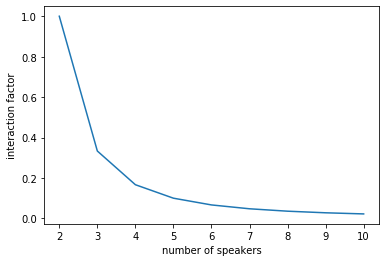

In [3]:
from math import comb
x=np.arange(2,11)
plt.plot(x,[1/comb(p,2) for p in x])
plt.xlabel('number of speakers')
plt.ylabel('interaction factor')

In [4]:
# get pair
co_df['speaker_pair'] = co_df['speaker1']+"-"+co_df['speaker2']
co_df.head()

,season,episode,scene,speaker1,speaker2,speaker_pair
0,1,1,1,Jim,Michael,Jim-Michael
1,1,1,3,Michael,Pam,Michael-Pam
2,1,1,7,Jim,Michael,Jim-Michael
3,1,1,7,Dwight,Michael,Dwight-Michael
4,1,1,7,Jim,Dwight,Jim-Dwight


In [5]:
#Get number of speakers per scene
num_speakers_pairs_per_scene = co_df.groupby(['season','episode','scene'])['speaker_pair'].nunique()\
                                 .reset_index(name='num_speaker_pairs')
num_speakers_pairs_per_scene

,season,episode,scene,num_speaker_pairs
0,1,1,1,1
1,1,1,3,1
2,1,1,7,3
3,1,1,10,3
4,1,1,11,3
...,...,...,...,...
5316,9,23,98,3
5317,9,23,99,3
5318,9,23,101,3
5319,9,23,107,6


In [6]:
co_df = co_df.merge(num_speakers_pairs_per_scene, on=['season','episode','scene'], how='left')
co_df

,season,episode,scene,speaker1,speaker2,speaker_pair,num_speaker_pairs
0,1,1,1,Jim,Michael,Jim-Michael,1
1,1,1,3,Michael,Pam,Michael-Pam,1
2,1,1,7,Jim,Michael,Jim-Michael,3
3,1,1,7,Dwight,Michael,Dwight-Michael,3
4,1,1,7,Jim,Dwight,Jim-Dwight,3
...,...,...,...,...,...,...,...
21683,9,23,107,Phyllis,Angela,Phyllis-Angela,6
21684,9,23,107,Jim,Creed,Jim-Creed,6
21685,9,23,107,Jim,Angela,Jim-Angela,6
21686,9,23,107,Angela,Creed,Angela-Creed,6


In [7]:
co_df['interaction_factor'] =1/co_df['num_speaker_pairs']
co_df

,season,episode,scene,speaker1,speaker2,speaker_pair,num_speaker_pairs,interaction_factor
0,1,1,1,Jim,Michael,Jim-Michael,1,1.000000
1,1,1,3,Michael,Pam,Michael-Pam,1,1.000000
2,1,1,7,Jim,Michael,Jim-Michael,3,0.333333
3,1,1,7,Dwight,Michael,Dwight-Michael,3,0.333333
4,1,1,7,Jim,Dwight,Jim-Dwight,3,0.333333
...,...,...,...,...,...,...,...,...
21683,9,23,107,Phyllis,Angela,Phyllis-Angela,6,0.166667
21684,9,23,107,Jim,Creed,Jim-Creed,6,0.166667
21685,9,23,107,Jim,Angela,Jim-Angela,6,0.166667
21686,9,23,107,Angela,Creed,Angela-Creed,6,0.166667


In [8]:
#save table with interaction factor
co_df.to_csv('data/the_office_speaker_pair_interaction_factors.csv', index=False)

## Build edgelist table

Our python network library `networkx` requires a specific pandas dataframe format to create a network out of it.

An *edgelist* is one way of representing a network in table form.

An edgelist is composed of at least 2 columns: 2 columns for the 2 nodes that are to be connected with an edge, and optionally, a third column containing a measure of the strength of the connection.

Our co-occurence table is an example of an edgelist table


In [9]:
#full series
data = co_df.groupby(['speaker1','speaker2'])['interaction_factor'].sum().reset_index(name='total_interaction_factor')
data.sort_values('total_interaction_factor')

,speaker1,speaker2,total_interaction_factor
110,DeAngelo,Creed,0.012821
111,DeAngelo,Oscar,0.012821
113,DeAngelo,Ryan,0.012821
494,Phyllis,DeAngelo,0.022222
28,Angela,Jo,0.022222
...,...,...,...
255,Jim,Michael,156.731197
416,Michael,Pam,200.843173
242,Jim,Dwight,260.987302
151,Dwight,Michael,343.880281


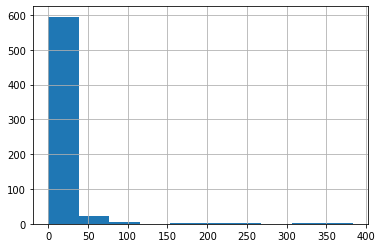

In [10]:
#check histogram
data['total_interaction_factor'].hist()

**Filter 1**: Remove pairs with total_interaction_factor<2

In [11]:
data = data[data['total_interaction_factor']>2]

In [12]:
len(data)

276

**Filter 2**: Get only top N interacting speaker pairs

In [14]:
#use quantiles to get a threshold
threshold = data['total_interaction_factor'].quantile(0.85)
threshold

29.308920246420257

In [15]:
print(len(data))
network_data = data[data['total_interaction_factor']>threshold]
print(len(network_data))

276
42


In [16]:
network_data.sort_values('total_interaction_factor')

,speaker1,speaker2,total_interaction_factor
263,Jim,Ryan,29.327950
344,Kevin,Dwight,30.328571
153,Dwight,Oscar,31.473016
12,Angela,Andy,32.018448
143,Dwight,Erin,33.816450
32,Angela,Michael,34.847813
328,Kelly,Ryan,35.644616
406,Michael,David,36.166667
331,Kevin,Andy,37.882784
351,Kevin,Jim,37.962149


## Constructing the network

In [17]:
import networkx as nx

In [18]:
#build network from edgelist
G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2', edge_attr='total_interaction_factor')


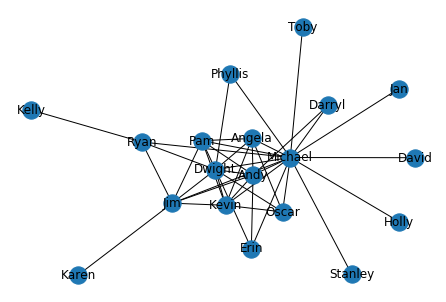

In [19]:
#plot network
nx.draw(G,with_labels = True)

## Network Navigation and Metrics

### Navigating the network

In [20]:
#get all nodes
G.nodes()

NodeView(('Andy', 'Erin', 'Pam', 'Angela', 'Dwight', 'Michael', 'Oscar', 'Darryl', 'Ryan', 'Jim', 'Karen', 'Kelly', 'Kevin', 'David', 'Holly', 'Jan', 'Toby', 'Phyllis', 'Stanley'))

In [21]:
#get all edges
G.edges()

EdgeView([('Andy', 'Erin'), ('Andy', 'Pam'), ('Andy', 'Angela'), ('Andy', 'Darryl'), ('Andy', 'Dwight'), ('Andy', 'Jim'), ('Andy', 'Kevin'), ('Andy', 'Michael'), ('Erin', 'Dwight'), ('Erin', 'Michael'), ('Pam', 'Angela'), ('Pam', 'Dwight'), ('Pam', 'Jim'), ('Pam', 'Kevin'), ('Pam', 'Michael'), ('Angela', 'Dwight'), ('Angela', 'Michael'), ('Angela', 'Oscar'), ('Angela', 'Kevin'), ('Dwight', 'Michael'), ('Dwight', 'Oscar'), ('Dwight', 'Ryan'), ('Dwight', 'Jim'), ('Dwight', 'Kevin'), ('Dwight', 'Phyllis'), ('Michael', 'Darryl'), ('Michael', 'Jim'), ('Michael', 'Kevin'), ('Michael', 'David'), ('Michael', 'Holly'), ('Michael', 'Jan'), ('Michael', 'Oscar'), ('Michael', 'Ryan'), ('Michael', 'Toby'), ('Michael', 'Phyllis'), ('Michael', 'Stanley'), ('Oscar', 'Kevin'), ('Ryan', 'Jim'), ('Ryan', 'Kelly'), ('Jim', 'Karen'), ('Jim', 'Kevin')])

In [22]:
#get neighbors
list(G.neighbors("Pam"))

['Andy', 'Angela', 'Dwight', 'Jim', 'Kevin', 'Michael']

A subgraph is a portion of a larger graph

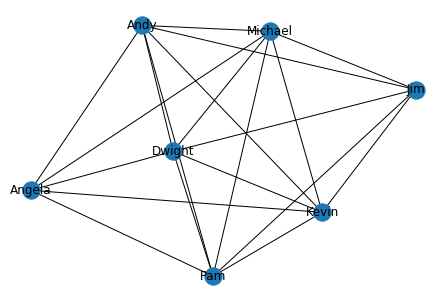

In [23]:
#subgraph of neighbors
Gsub = G.subgraph(list(G.neighbors("Pam"))+["Pam"])
nx.draw(Gsub,with_labels = True)

In [24]:
#shortest path
nx.shortest_path(G,"Kelly","Toby")

['Kelly', 'Ryan', 'Michael', 'Toby']

In [26]:
#average path length
print(nx.average_shortest_path_length(G))

1.9005847953216375


Average path length values: 

> exactly 1 = characters are 1 edge apart; all characters are directly connected to each other

> 1.0 to 2.0 = characters are 1-2 edges apart

> 2.0 above = characters are 2+ edges apart; a character most often stands in between 2 others (>3.0 unlikely for sitcoms)

### Centrality Measures

1. **Degree**
Degree is the number of edges connected to a node. 

In [27]:
G.degree()

DegreeView({'Andy': 8, 'Erin': 3, 'Pam': 6, 'Angela': 6, 'Dwight': 10, 'Michael': 16, 'Oscar': 4, 'Darryl': 2, 'Ryan': 4, 'Jim': 7, 'Karen': 1, 'Kelly': 1, 'Kevin': 7, 'David': 1, 'Holly': 1, 'Jan': 1, 'Toby': 1, 'Phyllis': 2, 'Stanley': 1})

In [28]:
#degree
metrics_df = pd.DataFrame(G.degree(), columns=['character','degree'])
metrics_df

,character,degree
0,Andy,8
1,Erin,3
2,Pam,6
3,Angela,6
4,Dwight,10
5,Michael,16
6,Oscar,4
7,Darryl,2
8,Ryan,4
9,Jim,7


2. **Betweenness centrality**
Betweenness centrality measures the number of times a node is present in the shortest path between 2 other nodes

In [29]:
nx.betweenness_centrality(G)

{'Andy': 0.036383442265795214,
 'Erin': 0.0,
 'Pam': 0.0026143790849673205,
 'Angela': 0.0032679738562091504,
 'Dwight': 0.08976034858387799,
 'Michael': 0.6289760348583877,
 'Oscar': 0.0,
 'Darryl': 0.0,
 'Ryan': 0.11111111111111112,
 'Jim': 0.12418300653594772,
 'Karen': 0.0,
 'Kelly': 0.0,
 'Kevin': 0.010239651416122004,
 'David': 0.0,
 'Holly': 0.0,
 'Jan': 0.0,
 'Toby': 0.0,
 'Phyllis': 0.0,
 'Stanley': 0.0}

In [30]:
#betweenness centrality
bc_df = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['character','betweenness_c'])
metrics_df = metrics_df.merge(bc_df, on='character', how='left')
metrics_df
#bw_vals

,character,degree,betweenness_c
0,Andy,8,0.036383
1,Erin,3,0.000000
2,Pam,6,0.002614
3,Angela,6,0.003268
4,Dwight,10,0.089760
5,Michael,16,0.628976
6,Oscar,4,0.000000
7,Darryl,2,0.000000
8,Ryan,4,0.111111
9,Jim,7,0.124183


3. **Eigenvector centrality**
Eigenvector centrality measures a node’s importance while giving consideration to the importance of its neighbors. 

In [31]:
#eigenvector centrality
eig_df = pd.DataFrame(nx.eigenvector_centrality(G).items()  , columns=['character','eigenvector_c'])
metrics_df = metrics_df.merge(eig_df, on='character', how='left')
metrics_df

,character,degree,betweenness_c,eigenvector_c
0,Andy,8,0.036383,0.341485
1,Erin,3,0.000000,0.171284
2,Pam,6,0.002614,0.305222
3,Angela,6,0.003268,0.294846
4,Dwight,10,0.089760,0.390711
5,Michael,16,0.628976,0.446400
6,Oscar,4,0.000000,0.212787
7,Darryl,2,0.000000,0.114502
8,Ryan,4,0.111111,0.168013
9,Jim,7,0.124183,0.294560


### Clustering

A clique is a subgraph within which all nodes are connected to each other

In [32]:
sitcom_cliques = list(nx.algorithms.clique.enumerate_all_cliques(G))
sitcom_cliques

[['Andy'],
 ['Erin'],
 ['Pam'],
 ['Angela'],
 ['Dwight'],
 ['Michael'],
 ['Oscar'],
 ['Darryl'],
 ['Ryan'],
 ['Jim'],
 ['Karen'],
 ['Kelly'],
 ['Kevin'],
 ['David'],
 ['Holly'],
 ['Jan'],
 ['Toby'],
 ['Phyllis'],
 ['Stanley'],
 ['Andy', 'Erin'],
 ['Andy', 'Pam'],
 ['Andy', 'Angela'],
 ['Andy', 'Dwight'],
 ['Andy', 'Michael'],
 ['Andy', 'Darryl'],
 ['Andy', 'Jim'],
 ['Andy', 'Kevin'],
 ['Erin', 'Dwight'],
 ['Erin', 'Michael'],
 ['Pam', 'Angela'],
 ['Pam', 'Dwight'],
 ['Pam', 'Michael'],
 ['Pam', 'Jim'],
 ['Pam', 'Kevin'],
 ['Angela', 'Dwight'],
 ['Angela', 'Michael'],
 ['Angela', 'Oscar'],
 ['Angela', 'Kevin'],
 ['Dwight', 'Michael'],
 ['Dwight', 'Oscar'],
 ['Dwight', 'Ryan'],
 ['Dwight', 'Jim'],
 ['Dwight', 'Kevin'],
 ['Dwight', 'Phyllis'],
 ['Michael', 'Oscar'],
 ['Michael', 'Darryl'],
 ['Michael', 'Ryan'],
 ['Michael', 'Jim'],
 ['Michael', 'Kevin'],
 ['Michael', 'David'],
 ['Michael', 'Holly'],
 ['Michael', 'Jan'],
 ['Michael', 'Toby'],
 ['Michael', 'Phyllis'],
 ['Michael', 'Stanley'

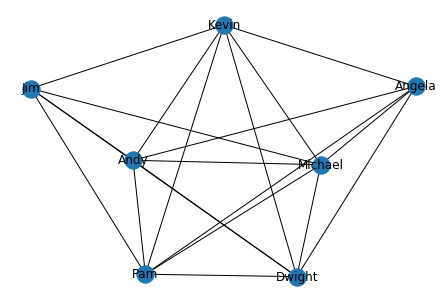

In [35]:
#largest clique
Gsub = G.subgraph(sitcom_cliques[-2]+["Jim"])
nx.draw(Gsub,with_labels = True)

A community is a local clustering of nodes 

In [36]:
from networkx.algorithms import community

community_lookup =[list(x) for x in community.greedy_modularity_communities(G)]
community_lookup


[['Dwight', 'Phyllis', 'Kevin', 'Angela', 'Pam', 'Oscar'],
 ['Michael', 'Jan', 'David', 'Stanley', 'Holly', 'Toby'],
 ['Karen', 'Kelly', 'Ryan', 'Jim'],
 ['Andy', 'Erin', 'Darryl']]

## Interactive Visualization

In [37]:
#add group number and size as node attribute
for character in metrics_df['character']:
    G.nodes[character]['size']=metrics_df[metrics_df['character']==character]['degree'].values[0]+4
    G.nodes[character]['group']=[n+1 for n,x in enumerate(community_lookup) if character in x][0]

In [38]:
#check if the attributes were properly loaded
G.nodes(data=True)

NodeDataView({'Andy': {'size': 12, 'group': 4}, 'Erin': {'size': 7, 'group': 4}, 'Pam': {'size': 10, 'group': 1}, 'Angela': {'size': 10, 'group': 1}, 'Dwight': {'size': 14, 'group': 1}, 'Michael': {'size': 20, 'group': 2}, 'Oscar': {'size': 8, 'group': 1}, 'Darryl': {'size': 6, 'group': 4}, 'Ryan': {'size': 8, 'group': 3}, 'Jim': {'size': 11, 'group': 3}, 'Karen': {'size': 5, 'group': 3}, 'Kelly': {'size': 5, 'group': 3}, 'Kevin': {'size': 11, 'group': 1}, 'David': {'size': 5, 'group': 2}, 'Holly': {'size': 5, 'group': 2}, 'Jan': {'size': 5, 'group': 2}, 'Toby': {'size': 5, 'group': 2}, 'Phyllis': {'size': 6, 'group': 1}, 'Stanley': {'size': 5, 'group': 2}})

In [41]:
#Pyvis to visualize the network interactively
#install by running in your terminal "pip install pyvis"
from pyvis.network import Network

In [42]:
g = Network(notebook=True,height='500px', width='100%')
g.from_nx(G)
g.show("the_office_network_viz.html")

### Further Reading
1. Crach course on basic network analysis in python [here](https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/)
2. In-depth network analysis with some literary explanations for Game of Thrones [here](https://networkofthrones.wordpress.com/)
